In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using TwoFAST, LaTeXStrings, LsqFit, MaximumLikelihoodPower

In [11]:
tab_pk = readdlm("../test/datatest/file_pk.txt", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);
k_min, k_max

(1.0e-8, 1000.0)

\begin{equation}
    \tilde{I}^4_0 (s) = \int \frac{dq}{2\pi^2} q^2P(q) \frac{j_0(qs) - 1}{(qs)^4}
\end{equation}

In [123]:
function func_I04_tilde(PK, s, kmin, kmax; kwargs...)
     res = quadgk(lq -> (sphericalbesselj(0, s * exp(lq)) - 1.0) * PK(exp(lq)) / (2.0 * π^2 * exp(lq)),
          log(kmin), log(kmax); kwargs...)[1]

     return res / (s^4)
end

power_law(x, si, b, a) = a .+ b .* (x .^ si)

function expanded_I04_tilde(PK, ss;
     kmin = 1e-6, kmax = 1e3, kwargs...)

     fit_1, fit_2 = 0.1, 1.0

     if all(ss .> fit_1)
          return [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in ss]
     else
          cutted_ss = ss[ss.>fit_1]
          cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]
          l_si, l_b, l_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
               [-2.0, -1.0, 0.0], fit_1, fit_2; con = true)
          #println("l_si, l_b, l_a = $l_si , $l_b , $l_a")
          left_I04_tildes = [GaPSE.power_law(s, l_si, l_b, l_a) for s in ss[ss.<=fit_1]]

          return vcat(left_I04_tildes, cutted_I04_tildes)
     end
end

expanded_I04_tilde (generic function with 1 method)

In [124]:
tab_mattia_I04_tildes = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/I40_tilde.txt");
mattia_I04_ss = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,1]);
mattia_I04_tildes = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,2]);
my_I04_tildes = expanded_I04_tilde(PK, mattia_I04_ss);

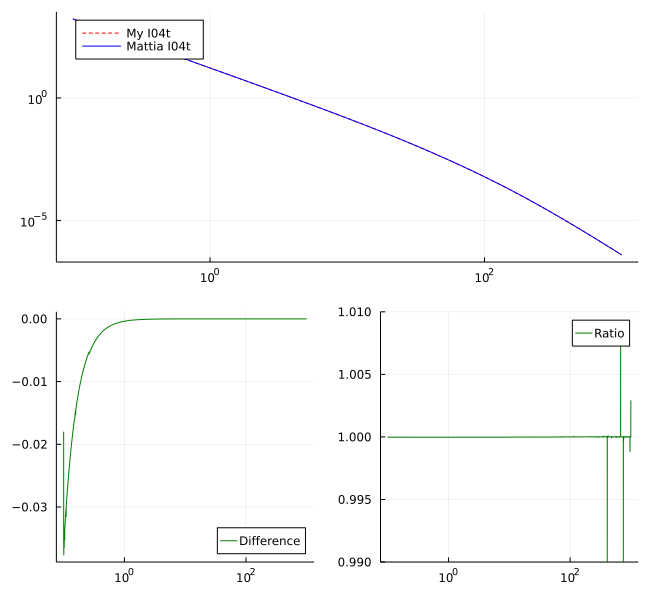

In [125]:
xs = mattia_I04_ss
ys = -mattia_I04_tildes
#spline = cosmo.tools.I04_tilde
my_ys = -my_I04_tildes

p1 = plot([xs[my_ys .>0], xs], [my_ys[my_ys .>0],  ys], xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My I04t" "Mattia I04t"], ls=[:dash :solid], legend=:topleft)

p2 = plot(xs, my_ys .- ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(xs, my_ys ./ ys, label="Ratio", lc=:green, xaxis=:log, ylim=(0.99, 1.01))

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

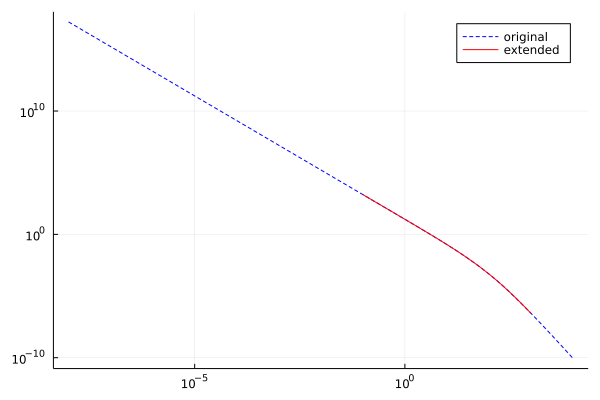

In [132]:
xs = 10 .^ range(-8, 4, length=1000)
ys = expanded_I04_tilde(PK, xs)
plot([xs, mattia_I04_ss], [-ys, -my_I04_tildes],
    label=["original" "extended"], lc=[:blue :red], ls=[:dash :solid],
    xaxis=:log, yaxis=:log)

In [134]:
open("I04_tilde_extended.txt", "w") do io
    println(io, "# s [Mpc/h_0] \t I04_tilde")
    [println(io, "$x \t $y") for (x, y) in zip(xs, ys)]
end

1000-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

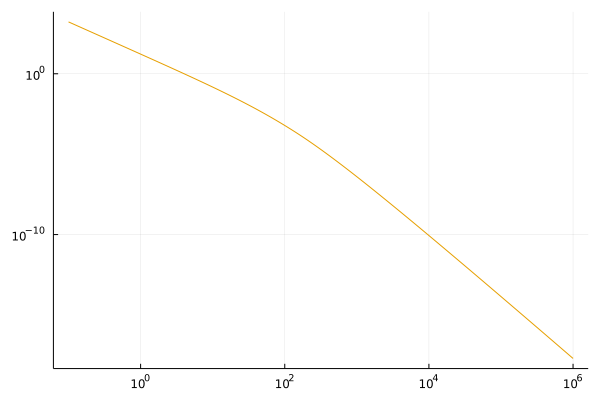

In [14]:
xs = 10 .^ range(-1, 6, length=1000)
ys = [func_I04_tilde(PK, x, k_min, k_max) for x in xs]
plot(xs, -ys, legend=false, xaxis=:log, yaxis=:log)

In [113]:
function power_law_from_data(xs, ys, p0, x1::Number, x2::Number; con = false)
     @assert length(xs) == length(ys) "xs and ys must have same length"
     new_xs = xs[x1.<xs.<x2]/1e4
     min_exp = min([log10(abs(y)) for y in ys[x1.<xs.<x2]]...) 
     enhancer = 10.0^(-min_exp)
    println("enhancer = $enhancer")
     new_ys = ys[x1.<xs.<x2] .* enhancer

     #si = mean_spectral_index(xs, ys; N=N, con=con)
     si, b, a =
          if con == false
               @assert length(p0) == 2 " si,b to be fitted, so length(p0) must be 2!"
               vec = coef(curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
                    new_xs, new_ys, p0))
               vcat(vec, 0.0)
          else
               @assert length(p0) == 3 " si,b,a to be fitted, so length(p0) must be 3!"
               coef(curve_fit((x, p) -> power_law(x, p[1], p[2], p[3]),
                    new_xs, new_ys, p0))
          end

     return si, b / 1e4^(si) / enhancer, a / enhancer
end

power_law_from_data (generic function with 1 method)

enhancer = 1.1130509274913729e10
r_si, r_b, r_a = -3.708544648762859 , -60234.173992264776 , 1.643431249547903e-12


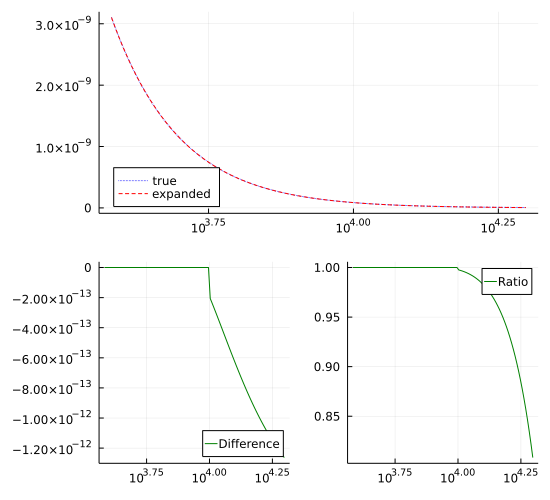

In [121]:
fit_3, fit_4 = 5e3, 1e4
cutted_xs = xs[xs.<fit_4]
cutted_ys = ys[xs.<fit_4]
r_si, r_b, r_a = power_law_from_data(cutted_xs, cutted_ys,
               [-4.0, -1e6, 0.0], fit_3, fit_4; con = true)
println("r_si, r_b, r_a = $r_si , $r_b , $r_a")
right_ys = [GaPSE.power_law(s, r_si, r_b, r_a) for s in xs[xs.>=fit_4]]

new_ys = vcat(cutted_ys, right_ys)

lim_xs = xs[lim_inf.<xs.<lim_sup]
lim_ys = -ys[lim_inf.<xs.<lim_sup]
lim_new_ys = -new_ys[lim_inf.<xs.<lim_sup] #[x>fit_4 ?  r_a/4 : 0 for x in lim_xs]

lim_inf, lim_sup = 3.8e3, 2e4
p1 = plot([lim_xs, lim_xs], 
    [lim_ys, lim_new_ys], 
    legend=:bottomleft, 
    xaxis=:log, #yaxis=:log,
    label = ["true" "expanded"], lc=["blue" "red"], ls =[:dot :dash]
)

p2 = plot(lim_xs, lim_new_ys .- lim_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(lim_xs, lim_new_ys ./ lim_ys, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(550, 500), layout= @layout [ x ; y z ] )

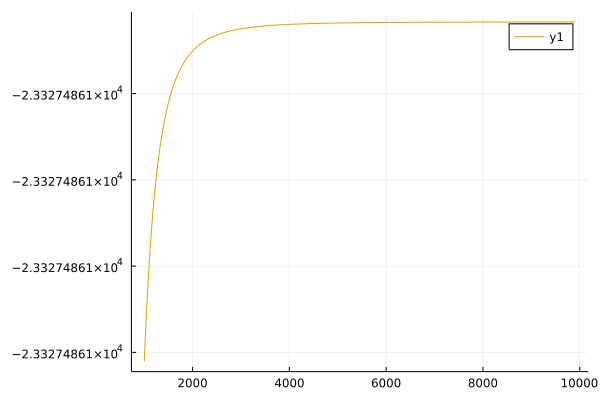

In [67]:
plot(new_xs, -18474 .* new_xs .^ (-3.556) .- 2.332748612241696e4)

enhancer = 1.1130509274913729e10


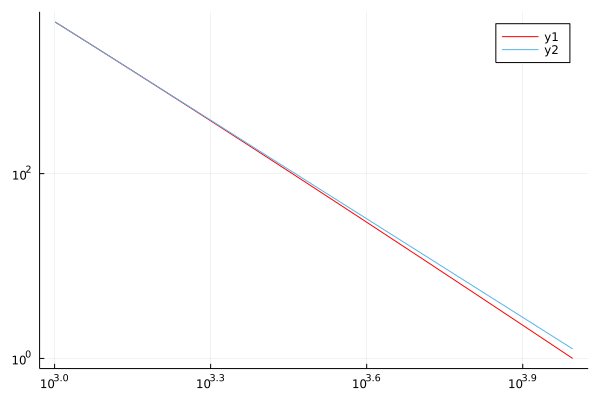

In [100]:
x1, x2 = 1e3, 1e4
new_xs = xs[x1.<xs.<x2]
min_exp = min([log10(abs(y)) for y in ys[x1.<xs.<x2]]...) 
enhancer = 10.0^(-min_exp)
println("enhancer = $enhancer")
new_ys = ys[x1.<xs.<x2] .* enhancer
plot(new_xs, -new_ys, xaxis=:log, yaxis=:log, lc="red")
a = 0 * (enhancer)
b = -18474.318788427034 * (-enhancer)
si = -3.556038580705523 
plot!(new_xs, a .+ b .* new_xs .^ (si))

In [ ]:
coef(curve_fit((x, p) -> power_law(x, p[1], p[2], p[3]), new_xs, new_ys, ))